In [11]:
# Neural Machine Translation Model

# keywords = Seq2Seq model with Attention, Bahdanau Attention, 
# GRU architecture, Seq to Seq RNN, 
# Sequence-to-Sequence GRU RNN architecture

In [12]:
# Importing Necessary Libraries

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time

In [13]:
# Prepping the dataset

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


In [14]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    
    w = w.strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    return w


In [15]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, DEUTSCH]

def create_dataset(path, num_examples):
    
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return zip(*word_pairs)


In [16]:
def tokenize(lang):
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    
    return tensor, lang_tokenizer


In [17]:
def load_dataset(path, num_examples=None):
    
    # creating cleaned input, output pairs
    
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer


In [18]:
path_to_file = '/content/deu.txt'

In [22]:
# Using first 95000 examples from dataset

num_examples = 95000

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [23]:
# Creating training, validation sets with 80-20 split ratio

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, 
                                                                                                target_tensor, 
                                                                                                test_size = 0.2)

# Printing lengths

print(len(input_tensor_train), 
      len(target_tensor_train), 
      len(input_tensor_val), 
      len(target_tensor_val)
     )


76000 76000 19000 19000


In [24]:
# Function to display how data is encoded

def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [25]:
print ("Input Language; index to word mapping")

convert(inp_lang, input_tensor_train[0])

print ()

print ("Target Language; index to word mapping")

convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
17 ----> die
2223 ----> arbeiter
14898 ----> grundeten
29 ----> eine
14899 ----> gewerkschaft
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
11 ----> the
2585 ----> workers
4297 ----> formed
10 ----> a
8510 ----> union
3 ----> .
2 ----> <end>


In [26]:
# Creating Tensorflow dataset object; 
# to easily access it while training


# Buffer Size while shuffling data

BUFFER_SIZE = len(input_tensor_train)

BATCH_SIZE = 64

steps_per_epoch = len(input_tensor_train) // BATCH_SIZE

# Size of Embedding Layer

embedding_dim = 256

# Number of hidden units in GRU

units = 1024

# Size of Vocabulary at Encoder (i.e., Spanish)

vocab_inp_size = len(inp_lang.word_index) + 1

# Size of Vocabulary at Decoder (i.e., English)

vocab_tar_size = len(targ_lang.word_index) + 1

# Creating a Tensorflow Dataset Object

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, 
                                              target_tensor_train)).shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE, 
                        drop_remainder = True)

In [27]:
example_input_batch, example_target_batch = next(iter(dataset))

print(example_input_batch.shape)
print()
print(example_target_batch.shape)

(64, 20)

(64, 14)


In [28]:
# Creating the Model, using Sequence-to-Sequence GRU RNN architecture

# Encoder - Decoder model with attention extension

# Creating Encoder
# Creating a Custom Layer

class Encoder(tf.keras.Model):
    
    def __init__(self,vocab_size,embedding_dim,enc_units,batch_sz):
        
        super(Encoder,self).__init__()
        
        '''
        vocab_size : Size of the Vocabulary
        embedding_dim : Size of the Embedding layer
        enc_units : No. of Hidden Units in the GRU
        batch_sz : Batch Size
        '''
        
        self.enc_units = enc_units
        self.batch_sz = batch_sz
        
        #Embedding Layer
        
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        
        #GRU
        
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences = True,
                                   return_state = True,
                                   recurrent_initializer = 'glorot_uniform')
    
    # Function to create model with the layers 
    
    def call(self,inp,hidden):
        
        '''
        inp: input to the model.i.e., vectorized form of the spanish sentence
        hidden: intial hidden_state of the gru.
        '''
        
        x = self.embedding(inp)
        
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    # Function to initialize the initial hidden state of GRU
    
    def initialize_hidden_state(self):
        
        return tf.zeros([self.batch_sz, 
                         self.enc_units]) 


In [29]:
encoder = Encoder(vocab_inp_size, 
                  embedding_dim, 
                  units, 
                  BATCH_SIZE
                 )

In [30]:
sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_hidden = encoder(example_input_batch, 
                                       sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))

print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [31]:
# Creating Bahdanau Attention

class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self,units):
        
        super(BahdanauAttention,self).__init__()
        
        '''
        units: Number of hidden Units , represented as "h_u" in the article
        '''
        
        self.units = units
        
        self.W1 = tf.keras.layers.Dense(self.units)
        
        self.W2 = tf.keras.layers.Dense(self.units)
        
        self.V = tf.keras.layers.Dense(1)
    
    
    #Function that will create the model with the layers 
    
    def call(self,query, values):
        
        '''
        query : The hidden state of the GRUs "refer to B"
        values: The output of the GRUs "refer to A"
        '''
        
        #To ccnvert the query from 2-D to 3-D
        
        query_with_time_axis = tf.expand_dims(query, 1)
        
        #Implementation of STEP-1
        
        '''Both query and Values are passed into a dense layer with units "h_u"
        and,added together,after that a tanh activation is applied and finally
        the result is passed into a dense layer with one neuron. ''' 
        
        score = self.V(tf.keras.activations.tanh(
            self.W1(query_with_time_axis) + self.W2(values))
                      )
        
        # Implementaion of STEP-2
        
        attention_weights = tf.keras.activations.softmax(score, 1)
        
        #Implementation of STEP-3 
        
        context_vector =  attention_weights * values
        
        context_vector = tf.reduce_sum(context_vector, 1)
        
        return context_vector, attention_weights


In [32]:
attention_layer = BahdanauAttention(10)

attention_result, attention_weights = attention_layer(sample_hidden, 
                                                      sample_output)

print("Attention result shape: (batch size, units) : {}".format(attention_result.shape))
print()
print("Attention weights shape: (batch_size, sequence_length, 1) : {}".format(attention_weights.shape))

Attention result shape: (batch size, units) : (64, 1024)

Attention weights shape: (batch_size, sequence_length, 1) : (64, 20, 1)


In [33]:
# Creating Decoder

# Creating a Custom Layer

class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        
        super(Decoder,self).__init__()
        
        '''
        vocab_size : Size of vocabulary for the resulting sentence (i.e.,English)
        embedding_dim : Size of the Embedding layer
        enc_units : No. of Hidden Units in the GRU
        batch_sz : Batch Size
        '''
        
        self.dec_units = dec_units
        
        self.batch_sz = batch_sz
        
        # Embedding layer
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                   embedding_dim)
        
        # GRU
        
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences = True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform')
        
        # Dense Layer
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # An Instance of attention layer 
        
        self.attention = BahdanauAttention(self.dec_units)
    
    
    #Function that will create the model with the layers 
    
    def call(self, x, hidden, enc_output):
        
        '''
        x :Input to the decoder
        hidden: Hidden state of the GRU
        enc_output: Output from the encoder layer (not attention layer)
        '''
        
        '''I combined the attention layer with the decoder layer.So that the attention 
        is calculated at the decoder.'''
        
        #Calculate attention vector
        
        context_vector, attention_weights = self.attention(hidden, 
                                                           enc_output)
        
        #Embedding Layer
        
        x = self.embedding(x)
        
        #Concating the attention vector with x
        
        x = tf.concat( [ tf.expand_dims(context_vector, 1), x ], 
                      axis = -1 )
        
        output, state = self.gru(x)
        
        #just Reshaaping the output i.e., (Batch_Size,Vocab_Dims)
        
        output = tf.reshape(output,(-1, output.shape[2]))
        
        #Passing it through a Dense layer
        
        x = self.fc(output)
        
        return x, state, attention_weights


In [34]:
decoder = Decoder(vocab_tar_size, 
                  embedding_dim, 
                  units, 
                  BATCH_SIZE
                 )

sample_decoder_output, _, _ = decoder(tf.random.uniform( (BATCH_SIZE, 1) ),
                                      sample_hidden, 
                                      sample_output
                                     )

print('Decoder output shape: (batch_size, vocab size) = {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) = (64, 9819)


In [35]:
# Training the Model

# using Adam Optimizer, and Sparse Categorical Cross Entropy loss

# Creating Optimizer Object

optimizer = tf.keras.optimizers.Adam()

# Creating Loss Object

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, 
                                                            reduction = 'none'
                                                           )

''' We will be taking bulks of data from the dataset while training
This function just uses the Loss Object to deal with a bulk of data, 
and calculate loss for the whole bulk'''

def loss_function(real, pred):
    
    mask = tf.math.logical_not( tf.math.equal(real, 0) )
    
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype = loss_.dtype)
    
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


In [36]:
# Storing Model Progress while Training

# Checkpoint Storing Path 

checkpoint_dir = './training_checkpoints'

# Index of Checkpoint

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# Checkpoint Object that will store the state of each layer

checkpoint = tf.train.Checkpoint(optimizer = optimizer,
                                 encoder = encoder,
                                 decoder = decoder
                                )

# we combined the Attention layer with the decoder layer so we don't
# have to save it explicitly.

In [37]:
def train_step(inp,targ,enc_hidden):
    
    loss = 0
    
    with tf.GradientTape() as tape:
        
        # Step-4
        
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        # Step-7
        
        dec_input = tf.expand_dims([ targ_lang.word_index['<start>'] ] * BATCH_SIZE, 
                                   1
                                  )
        
        # We have to concatenate the decoder input with the attention vector
        # So we have to convert it into 2-D by expanding Dims.
        
        for t in range(1, targ.shape[1]):
            
            predictions, dec_hidden,_ = decoder(dec_input, 
                                                dec_hidden, 
                                                enc_output
                                               )
            
            # Increment the loss,targ[:,t] means we are calculating loss for the 
            # t'th word in all batches at the same time.(BULK!)
            
            loss += loss_function(targ[:,t], predictions)
            
            # We have to concatenate the decoder input with the attention vector
            # So we have to convert it into 2-D by expanding Dims.
            
            dec_input = tf.expand_dims(targ[:,t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    
    # Get all the trainable variables
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    # Calculate Derivative
    
    gradients = tape.gradient(loss, variables)
    
    # Apply the gradients
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [38]:
# Defining the number of epochs

EPOCH = 15

for epoch in range(EPOCH):
    
    #To calculate time taken for each epoch
    
    start = time.time()
    
    # Initializing the hidden state of the Encoder model
    
    enc_hidden = encoder.initialize_hidden_state()
    
    # Initializing total loss, which is zero initially
    
    total_loss = 0
    
    # Taking batches of data
    
    for (batch,(inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, enc_hidden)
        
        total_loss += batch_loss
        
        #Printing stats after 100 batches
        
        if batch % 100 == 0:
            
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()
                                                        ) )
        
    # saving (checkpoint) the model every 2 epochs
        
    if (epoch + 1) % 2 == 0:
            
        checkpoint.save(file_prefix = checkpoint_prefix)
            
    #Printing some stats.
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
        
    print()
        
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.7294
Epoch 1 Batch 100 Loss 2.1914
Epoch 1 Batch 200 Loss 2.0314
Epoch 1 Batch 300 Loss 1.6942
Epoch 1 Batch 400 Loss 1.8506
Epoch 1 Batch 500 Loss 1.6889
Epoch 1 Batch 600 Loss 1.4352
Epoch 1 Batch 700 Loss 1.3825
Epoch 1 Batch 800 Loss 1.4946
Epoch 1 Batch 900 Loss 1.2470
Epoch 1 Batch 1000 Loss 1.1410
Epoch 1 Batch 1100 Loss 1.1949
Epoch 1 Loss 1.6227

Time taken for 1 epoch 503.5951602458954 sec

Epoch 2 Batch 0 Loss 0.9797
Epoch 2 Batch 100 Loss 1.0613
Epoch 2 Batch 200 Loss 1.0554
Epoch 2 Batch 300 Loss 1.0541
Epoch 2 Batch 400 Loss 0.8628
Epoch 2 Batch 500 Loss 0.7814
Epoch 2 Batch 600 Loss 0.9397
Epoch 2 Batch 700 Loss 0.8902
Epoch 2 Batch 800 Loss 0.8064
Epoch 2 Batch 900 Loss 0.8485
Epoch 2 Batch 1000 Loss 0.8857
Epoch 2 Batch 1100 Loss 0.7488
Epoch 2 Loss 0.8739

Time taken for 1 epoch 489.92234349250793 sec

Epoch 3 Batch 0 Loss 0.5439
Epoch 3 Batch 100 Loss 0.5394
Epoch 3 Batch 200 Loss 0.5818
Epoch 3 Batch 300 Loss 0.5305
Epoch 3 Batch 400 Loss 0.48

In [39]:
#Function that translates a given sentence
def evaluate(sentence):
    
    #This is to store the attention vector for plotting.Ignore this
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    #Preprocessing the sentence.Steps 2,3 and 4
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    
    #Step 4
    inputs = tf.convert_to_tensor(inputs)
    
    #creating a string to store the translated sentence
    result = ''

    #Step 5
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden

    #Step 6
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    #Step 7
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on.Ignore it
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        #Step 8
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
        
    #Return the Original Sentence,Translated Sentence and the history of attention weights
    return result, sentence, attention_plot

In [40]:
sentence = u'Ich hab gewonnen!'
translation,_,_ = evaluate(sentence)
print(translation)

i won ! <end> 


In [41]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [42]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    
    print('Input: %s' % (sentence))
    print('Translation: {}'.format(result))
    print()
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> ich hab gewonnen ! <end>
Predicted translation: i won ! <end> 


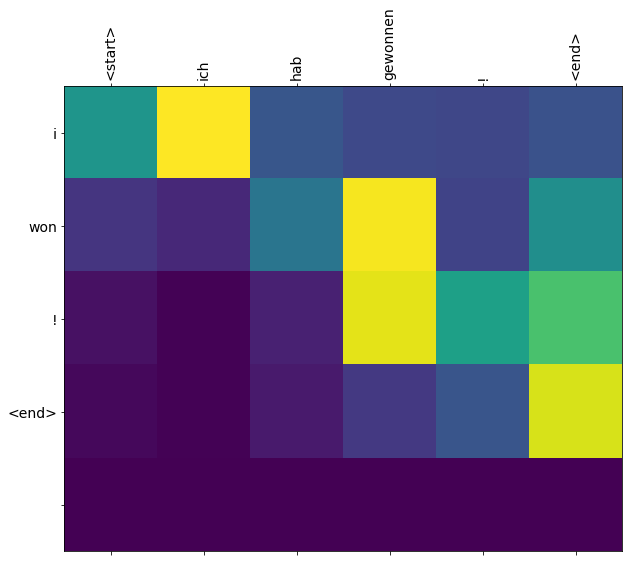

In [44]:
translate(u'Ich hab gewonnen!')

Input: <start> hallo ! <end>
Predicted translation: hello ! <end> 


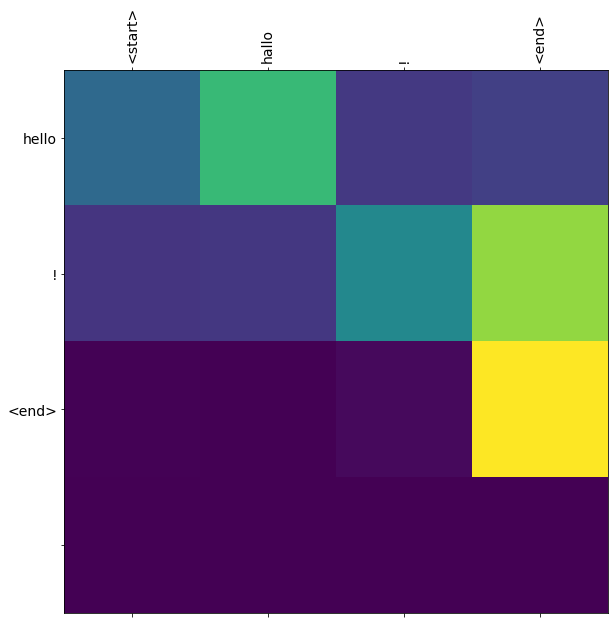

In [45]:
translate(u'Hallo!')

Input: <start> willkommen ! <end>
Predicted translation: welcome . <end> 


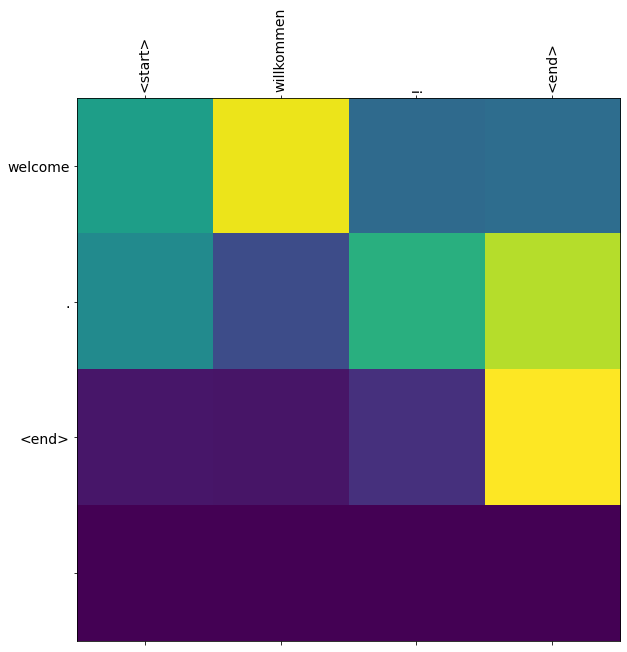

In [50]:
translate(u'Willkommen!')

Input: <start> lamia . <end>
Predicted translation: lamia . <end> 


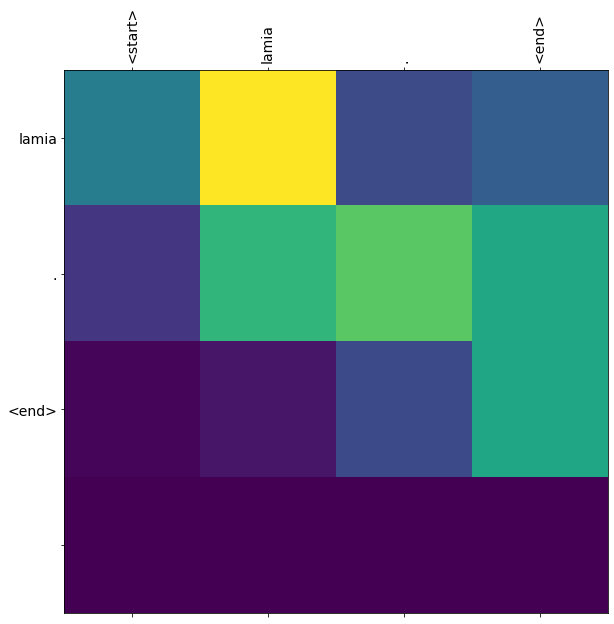

In [51]:
translate(u'Lamia.')